In [237]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
import math
import os

In [238]:
duration_df = pd.read_csv(f'Trace Analysis - durations.tsv', sep='\t')
duration_df

,mem_state,run,duration
0,Normal,1,39123.00088
1,Normal,2,39230.95389
2,Normal,3,39226.55989
3,Moderate,1,39186.83797
4,Moderate,2,39028.42234
5,Moderate,3,39388.73722
6,Critical,1,37237.71200
7,Critical,2,16521.31870
8,Critical,3,16512.59377


In [239]:
main_df = pd.DataFrame()
for mem_state in ['Normal', 'Moderate', 'Critical']:
    for run in [1, 2, 3]:
        to_append = pd.read_csv(f'Trace Analysis - {mem_state[0].lower()}_{run}.tsv', sep='\t')
        to_append['mem_state'] = mem_state
        to_append['run'] = run
        duration = duration_df.loc[duration_df['mem_state'] == mem_state].loc[duration_df['run'] == run]['duration'].iloc[0]
        to_append['duration'] = duration
        to_append['Percentage Time Spent (%)'] = (to_append['Wall duration (ms)']/duration)*100
        to_append['Time Spent (s)'] = to_append['Wall duration (ms)']/1000
        main_df = main_df.append(to_append, ignore_index=True)
main_df

,Process,PID,Thread,TID,State,Wall duration (ms),Avg Wall duration (ms),Occurrences,mem_state,run,duration,Percentage Time Spent (%),Time Spent (s)
0,org.mozilla.firefox,8452,JS Watchdog,8542,Sleeping,39001.202280,975.030057,40,Normal,1,39123.00088,9.968868e+01,3.900120e+01
1,org.mozilla.firefox,8452,mali-mem-purge,8590,Sleeping,38923.994040,98.791863,394,Normal,1,39123.00088,9.949133e+01,3.892399e+01
2,/system/bin/surfaceflinger,3534,surfaceflinger,3550,Sleeping,38906.643430,120.828085,322,Normal,1,39123.00088,9.944698e+01,3.890664e+01
3,/system/bin/surfaceflinger,3534,sf,3549,Sleeping,38859.562950,25.103076,1548,Normal,1,39123.00088,9.932664e+01,3.885956e+01
4,org.mozilla.firefox,8452,mali-hist-dump,8596,Sleeping,38817.826720,99.278329,391,Normal,1,39123.00088,9.921996e+01,3.881783e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9564,org.mozilla.firefox,16822,StreamTrans #34,17281,Task Dead,-0.000001,-0.000001,1,Critical,3,16512.59377,-6.055984e-09,-1.000000e-09
9565,org.mozilla.firefox,16822,StreamTrans #35,17282,Task Dead,-0.000001,-0.000001,1,Critical,3,16512.59377,-6.055984e-09,-1.000000e-09
9566,org.mozilla.firefox,16822,StreamTrans #36,17283,Task Dead,-0.000001,-0.000001,1,Critical,3,16512.59377,-6.055984e-09,-1.000000e-09
9567,org.mozilla.firefox,16822,StreamTrans #37,17374,Task Dead,-0.000001,-0.000001,1,Critical,3,16512.59377,-6.055984e-09,-1.000000e-09


In [240]:
df = main_df[['Process', 'State', 'Wall duration (ms)', 'Avg Wall duration (ms)', 'Occurrences', 'mem_state', 'run', 'Time Spent (s)']]
df['run'] = df['run'].astype(str)
df['mem_state_run'] = df['mem_state'] + ' Run #' + df['run']

def drop_from_df(df, label, label_name='State'):
    to_drop = df.loc[df[label_name] == label].index
    df = df.drop(index=to_drop)
    return df

for label in ['Task Dead', 'Parked', 'undefined (non-IO) + No Load + undefined + undefined + undefined + undefined', 'Sleeping', 'Uninterruptible Sleep + Wake Kill', 'Uninterruptible Sleep']:
    df = drop_from_df(df, label)
    
df = drop_from_df(df, 'kthreadd', label_name='Process')

df = drop_from_df(df, 'Critical', label_name='mem_state')

df = df.groupby(['mem_state', 'run', 'State']).sum() #.to_frame(name = 'count').reset_index()
df.to_csv('temp')
df = pd.read_csv('temp')
df

df = df.groupby(['mem_state', 'State']).sum() #.to_frame(name = 'count').reset_index()
df.to_csv('temp')
df = pd.read_csv('temp')
df

<ipython-input-240-3a2055d2cdff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['run'] = df['run'].astype(str)
<ipython-input-240-3a2055d2cdff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mem_state_run'] = df['mem_state'] + ' Run #' + df['run']


,mem_state,State,run,Wall duration (ms),Avg Wall duration (ms),Occurrences,Time Spent (s)
0,Moderate,Runnable,6,217052.311236,376.082904,554495,217.052311
1,Moderate,Runnable (Preempted),6,79086.734040,326.008233,121127,79.086734
2,Moderate,Running,6,189500.265786,156.606639,689025,189.500266
3,Normal,Runnable,6,174745.528111,160.549009,674336,174.745528
4,Normal,Runnable (Preempted),6,39990.595475,170.065608,80504,39.990595
5,Normal,Running,6,207028.226262,128.839022,778474,207.028226


-8.466459280686639 24.21050975228743 97.76333185496271


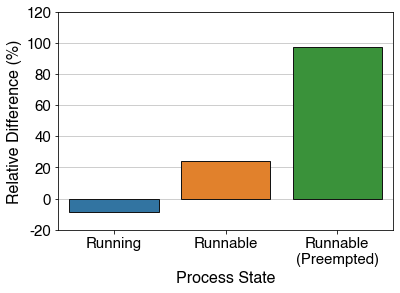

In [242]:
i = 0
runnable_inc = ((df.loc[i, 'Time Spent (s)'] - df.loc[i+3, 'Time Spent (s)']) / df.loc[i+3, 'Time Spent (s)'])*100
i = 1
runnable_preempted_inc = ((df.loc[i, 'Time Spent (s)'] - df.loc[i+3, 'Time Spent (s)']) / df.loc[i+3, 'Time Spent (s)'])*100
i = 2
running_inc = ((df.loc[i, 'Time Spent (s)'] - df.loc[i+3, 'Time Spent (s)']) / df.loc[i+3, 'Time Spent (s)'])*100

print(running_inc, runnable_inc, runnable_preempted_inc)

fig, (ax) = plt.subplots(1, 1, figsize=(6, 4))

sns.barplot(ax=ax, x=['Running', 'Runnable', 'Runnable (Preempted)'], y=[running_inc, runnable_inc, runnable_preempted_inc],
           edgecolor='#141414', linewidth=1)

# ax.set_title("Sum of Time Spent in Process States for Threads of Firefox, MediaCodec and SurfaceFlinger")
ax.set_xlabel('Process State', fontsize=16)
ax.set_ylabel('Relative Difference (%)', fontsize=16)

ax.set_yticks(range(-20,120+10,20))
ax.set_yticklabels(range(-20,120+10,20), fontsize=15)
ax.set_xticklabels(['Running', 'Runnable', 'Runnable\n(Preempted)'], fontsize=15)

ax.set_axisbelow(True)
ax.yaxis.grid(color='#C2C2C2')

plt.savefig(f"./systrace_1.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)

In [148]:
df = main_df[['Process', 'State', 'Wall duration (ms)', 'Avg Wall duration (ms)', 'Occurrences', 'mem_state', 'run', 'Time Spent (s)']]
df['run'] = df['run'].astype(str)
df['mem_state_run'] = df['mem_state'] + ' Run #' + df['run']

def drop_from_df(df, label, label_name='State'):
    to_drop = df.loc[df[label_name] == label].index
    df = df.drop(index=to_drop)
    return df

for label in ['Task Dead', 'Parked', 'undefined (non-IO) + No Load + undefined + undefined + undefined + undefined', 'Sleeping', 'Uninterruptible Sleep + Wake Kill', 'Uninterruptible Sleep']:
    df = drop_from_df(df, label)
    
df = drop_from_df(df, 'kthreadd', label_name='Process')

df = drop_from_df(df, 'Critical', label_name='mem_state')

df = df.groupby(['mem_state_run', 'State']).sum() #.to_frame(name = 'count').reset_index()
df.to_csv('temp')
df1 = pd.read_csv('temp')
df1['mem_state'] = df1['mem_state_run'].apply(lambda label: re.search(r'(.*) Run',label).group(1))
df1

<ipython-input-148-05447d9c4710>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['run'] = df['run'].astype(str)
<ipython-input-148-05447d9c4710>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mem_state_run'] = df['mem_state'] + ' Run #' + df['run']


,mem_state_run,State,Wall duration (ms),Avg Wall duration (ms),Occurrences,Time Spent (s),mem_state
0,Moderate Run #1,Runnable,74692.487074,144.296922,181623,74.692487,Moderate
1,Moderate Run #1,Runnable (Preempted),28441.180372,116.000750,41133,28.441180,Moderate
2,Moderate Run #1,Running,62740.143888,51.431553,227034,62.740144,Moderate
3,Moderate Run #2,Runnable,70677.130109,100.289541,183490,70.677130,Moderate
4,Moderate Run #2,Runnable (Preempted),24708.650939,99.384824,39545,24.708651,Moderate
5,Moderate Run #2,Running,63564.947795,52.916793,227545,63.564948,Moderate
6,Moderate Run #3,Runnable,71682.694053,131.496441,189382,71.682694,Moderate
7,Moderate Run #3,Runnable (Preempted),25936.902729,110.622659,40449,25.936903,Moderate
8,Moderate Run #3,Running,63195.174103,52.258293,234446,63.195174,Moderate
9,Normal Run #1,Runnable,60928.807160,52.989494,221846,60.928807,Normal


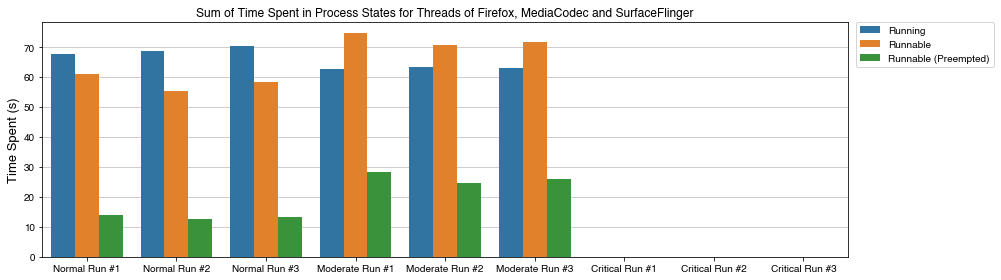

In [145]:
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 4))

ax = ax1

sns.barplot(ax=ax, data=df1, x='mem_state_run', y='Time Spent (s)', hue='State',
           order=['Normal Run #1', 'Normal Run #2', 'Normal Run #3',
                  'Moderate Run #1', 'Moderate Run #2', 'Moderate Run #3',
                  'Critical Run #1', 'Critical Run #2', 'Critical Run #3'],
           hue_order=['Running', 'Runnable', 'Runnable (Preempted)'])

ax.set_title("Sum of Time Spent in Process States for Threads of Firefox, MediaCodec and SurfaceFlinger")
ax.set_xlabel('')
ax.set_ylabel('Time Spent (s)', fontsize=13)

ax.set_axisbelow(True)
ax.yaxis.grid(color='#C2C2C2')

ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.savefig(f"./systrace_1.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.5)

# df = df.loc[df['State'] == 'Runnable'].append(df.loc[df['State'] == 'Runnable (Preempted)'], ignore_index=True)


# ax = ax2

# sns.barplot(ax=ax, data=df, x='mem_state_run', y='Time Spent (s)', hue='State',
#            order=['Normal Run #1', 'Normal Run #2', 'Normal Run #3',
#                   'Moderate Run #1', 'Moderate Run #2', 'Moderate Run #3',
#                   'Critical Run #1', 'Critical Run #2', 'Critical Run #3'],
#            hue_order=['Running', 'Runnable', 'Runnable (Preempted)'])

# ax.set_title("Sum of Time Spent in Process States for Firefox, MediaCodec")
# ax.set_xlabel('')
# ax.set_ylabel('Time Spent (s)', fontsize=13)

# ax.set_axisbelow(True)
# ax.yaxis.grid(color='#C2C2C2')

# ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()

In [131]:
df.loc[df['State'] == 'Runnable'].append(df.loc[df['State'] == 'Runnable (Preempted)'], ignore_index=True).groupby(['mem_state_run']).sum()

,Wall duration (ms),Avg Wall duration (ms),Occurrences,Time Spent (s)
mem_state_run,,,,
Moderate Run #1,103133.667446,260.297672,222756,103.133667
Moderate Run #2,95385.781048,199.674365,223035,95.385781
Moderate Run #3,97619.596782,242.119100,229831,97.619597
Normal Run #1,74784.931535,112.794316,249339,74.784932
Normal Run #2,68232.875077,125.726009,250802,68.232875
Normal Run #3,71718.316974,92.094292,254699,71.718317


In [175]:
"""Plot kswapd stats"""

kswapd_df = main_df.loc[main_df['Thread'] == 'kswapd0']
kswapd_df['run'] = kswapd_df['run'].astype(str)
kswapd_df['mem_state_run'] = kswapd_df['mem_state'] + ' Run #' + kswapd_df['run']
# kswapd_df

def drop_from_df(df, label, label_name='State'):
    to_drop = df.loc[df[label_name] == label].index
    df = df.drop(index=to_drop)
    return df

for label in ['Task Dead', 'Parked', 'undefined (non-IO) + No Load + undefined + undefined + undefined + undefined', 'Uninterruptible Sleep + Wake Kill', 'Uninterruptible Sleep']:
    kswapd_df = drop_from_df(kswapd_df, label)

kswapd_df = drop_from_df(kswapd_df, 'Critical', label_name='mem_state')

kswapd_df

<ipython-input-175-43b9450dbcf8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kswapd_df['run'] = kswapd_df['run'].astype(str)
<ipython-input-175-43b9450dbcf8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kswapd_df['mem_state_run'] = kswapd_df['mem_state'] + ' Run #' + kswapd_df['run']


,Process,PID,Thread,TID,State,Wall duration (ms),Avg Wall duration (ms),Occurrences,mem_state,run,duration,Percentage Time Spent (%),Time Spent (s),mem_state_run
646,kthreadd,2,kswapd0,85,Sleeping,29051.141670,32.136218,904,Normal,1,39123.00088,74.255913,29.051142,Normal Run #1
665,kthreadd,2,kswapd0,85,Running,3466.393852,0.839727,4128,Normal,1,39123.00088,8.860245,3.466394,Normal Run #1
666,kthreadd,2,kswapd0,85,Runnable (Preempted),2499.074461,0.869243,2875,Normal,1,39123.00088,6.387737,2.499074,Normal Run #1
673,kthreadd,2,kswapd0,85,Runnable,850.733147,0.690530,1232,Normal,1,39123.00088,2.174509,0.850733,Normal Run #1
988,kthreadd,2,kswapd0,85,Sleeping,30346.796920,37.008288,820,Normal,2,39230.95389,77.354216,30.346797,Normal Run #2
1049,kthreadd,2,kswapd0,85,Running,1955.084684,0.698993,2797,Normal,2,39230.95389,4.983526,1.955085,Normal Run #2
1075,kthreadd,2,kswapd0,85,Runnable (Preempted),1272.681681,0.779829,1632,Normal,2,39230.95389,3.244075,1.272682,Normal Run #2
1101,kthreadd,2,kswapd0,85,Runnable,811.510850,0.700786,1158,Normal,2,39230.95389,2.068547,0.811511,Normal Run #2
1818,kthreadd,2,kswapd0,85,Sleeping,28608.897150,49.071864,583,Normal,3,39226.55989,72.932465,28.608897,Normal Run #3
1901,kthreadd,2,kswapd0,85,Running,1390.644884,0.775596,1793,Normal,3,39226.55989,3.545161,1.390645,Normal Run #3


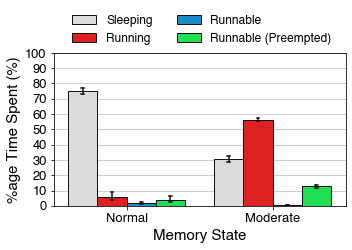

In [268]:
fig, ax2 = plt.subplots(1, 1, figsize=(5,3))

# ax = ax1

# sns.barplot(ax=ax, data=kswapd_df, x='mem_state_run', y='Occurrences', hue='State')

# ax.set_title("kswapd Thread's Usage of the CPU")
# ax.set_xlabel('')
# ax.set_ylabel('Time Spent (s)', fontsize=13)

# ax.set_axisbelow(True)
# ax.yaxis.grid(color='#C2C2C2')

# ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

ax = ax2

sns.barplot(ax=ax, data=kswapd_df, x='mem_state', y='Percentage Time Spent (%)', hue='State',
            hue_order=['Sleeping', 'Running', 'Runnable', 'Runnable (Preempted)'],
            palette={'Sleeping': '#DBDBDB', 'Running': 'red', 'Runnable': '#0092E6', 'Runnable (Preempted)': '#00FF43'},
           edgecolor='#141414', linewidth=1,
           capsize=.02, errwidth=1.5, errcolor='#141414')

ax.set_title("")
ax.set_xlabel('Memory State', fontsize=15)
ax.set_ylabel('%age Time Spent (%)', fontsize=15)

ax.set_yticks(range(0,100+10,10))
ax.set_yticklabels(range(0,100+10,10), fontsize=13)
ax.set_xticklabels(['Normal', 'Moderate'], fontsize=13)

ax.set_axisbelow(True)
ax.yaxis.grid(color='#C2C2C2')

plt.tight_layout()
ax.legend(bbox_to_anchor=(0.04, 1.3), loc=2, fontsize=12, borderaxespad=0., borderpad=0.6, ncol=2, frameon=False)

plt.savefig(f"./systrace_final.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)

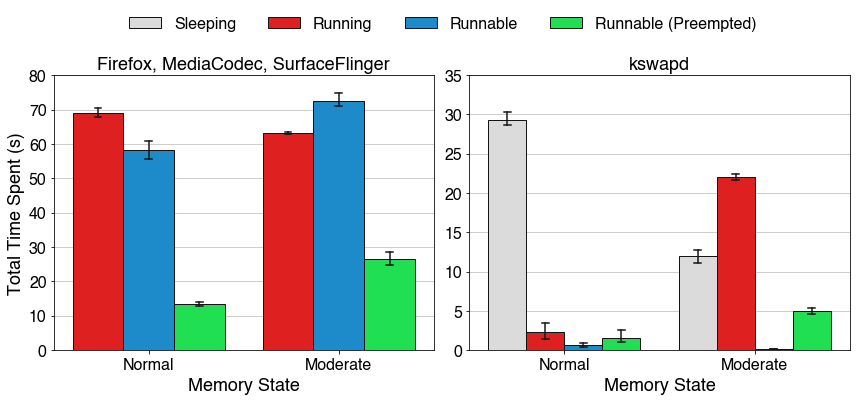

In [222]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# ax = ax1

# sns.barplot(ax=ax, data=kswapd_df, x='mem_state_run', y='Occurrences', hue='State')

# ax.set_title("kswapd Thread's Usage of the CPU")
# ax.set_xlabel('')
# ax.set_ylabel('Time Spent (s)', fontsize=13)

# ax.set_axisbelow(True)
# ax.yaxis.grid(color='#C2C2C2')

# ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

ax = ax1

sns.barplot(ax=ax, data=df1, x='mem_state', y='Time Spent (s)', hue='State',
           order=['Normal', 'Moderate'],
           hue_order=['Running', 'Runnable', 'Runnable (Preempted)'],
            palette={'Running': 'red', 'Runnable': '#0092E6', 'Runnable (Preempted)': '#00FF43'},
           edgecolor='#141414', linewidth=1,
           capsize=.035, errwidth=1.5, errcolor='#141414')

ax.set_yticks(range(0,80+1,10))
ax.set_yticklabels(range(0,80+1,10), fontsize=16)
ax.set_xticklabels(['Normal', 'Moderate'], fontsize=16)

ax.set_title("Firefox, MediaCodec, SurfaceFlinger", fontsize=18)
ax.set_xlabel('Memory State', fontsize=18)
ax.set_ylabel('Total Time Spent (s)', fontsize=18)

ax.set_axisbelow(True)
ax.yaxis.grid(color='#C2C2C2')

ax.get_legend().remove()

# ax.legend(bbox_to_anchor=(0.03, 1.25), loc=2, fontsize=14, borderaxespad=0., borderpad=0.6, ncol=2, frameon=False)

ax = ax2

sns.barplot(ax=ax, data=kswapd_df, x='mem_state', y='Time Spent (s)', hue='State',
            hue_order=['Sleeping', 'Running', 'Runnable', 'Runnable (Preempted)'],
            palette={'Sleeping': '#DBDBDB', 'Running': 'red', 'Runnable': '#0092E6', 'Runnable (Preempted)': '#00FF43'},
           edgecolor='#141414', linewidth=1,
           capsize=.035, errwidth=1.5, errcolor='#141414')

ax.set_title("kswapd", fontsize=18)
ax.set_xlabel('Memory State', fontsize=18)
ax.set_ylabel('', fontsize=18)

ax.set_yticks(range(0,35+1,5))
ax.set_yticklabels(range(0,35+1,5), fontsize=16)
ax.set_xticklabels(['Normal', 'Moderate'], fontsize=16)

ax.set_axisbelow(True)
ax.yaxis.grid(color='#C2C2C2')

plt.tight_layout()

ax.legend(bbox_to_anchor=(-0.92, 1.25), loc=2, fontsize=16, borderaxespad=0., borderpad=0.6, ncol=4, frameon=False)

plt.savefig(f"./systrace_final.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)

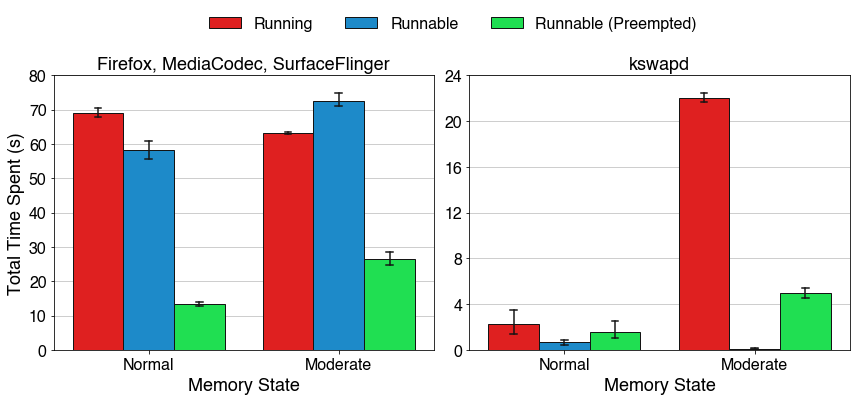

In [236]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# ax = ax1

# sns.barplot(ax=ax, data=kswapd_df, x='mem_state_run', y='Occurrences', hue='State')

# ax.set_title("kswapd Thread's Usage of the CPU")
# ax.set_xlabel('')
# ax.set_ylabel('Time Spent (s)', fontsize=13)

# ax.set_axisbelow(True)
# ax.yaxis.grid(color='#C2C2C2')

# ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

ax = ax1

sns.barplot(ax=ax, data=df1, x='mem_state', y='Time Spent (s)', hue='State',
           order=['Normal', 'Moderate'],
           hue_order=['Running', 'Runnable', 'Runnable (Preempted)'],
            palette={'Running': 'red', 'Runnable': '#0092E6', 'Runnable (Preempted)': '#00FF43'},
           edgecolor='#141414', linewidth=1,
           capsize=.035, errwidth=1.5, errcolor='#141414')

ax.set_yticks(range(0,80+1,10))
ax.set_yticklabels(range(0,80+1,10), fontsize=16)
ax.set_xticklabels(['Normal', 'Moderate'], fontsize=16)

ax.set_title("Firefox, MediaCodec, SurfaceFlinger", fontsize=18)
ax.set_xlabel('Memory State', fontsize=18)
ax.set_ylabel('Total Time Spent (s)', fontsize=18)

ax.set_axisbelow(True)
ax.yaxis.grid(color='#C2C2C2')

ax.get_legend().remove()

# ax.legend(bbox_to_anchor=(0.03, 1.25), loc=2, fontsize=14, borderaxespad=0., borderpad=0.6, ncol=2, frameon=False)

ax = ax2

sns.barplot(ax=ax, data=kswapd_df, x='mem_state', y='Time Spent (s)', hue='State',
            hue_order=['Running', 'Runnable', 'Runnable (Preempted)'],
            palette={'Running': 'red', 'Runnable': '#0092E6', 'Runnable (Preempted)': '#00FF43'},
           edgecolor='#141414', linewidth=1,
           capsize=.035, errwidth=1.5, errcolor='#141414')

ax.set_title("kswapd", fontsize=18)
ax.set_xlabel('Memory State', fontsize=18)
ax.set_ylabel('', fontsize=18)

ax.set_yticks(range(0,24+1,4))
ax.set_yticklabels(range(0,24+1,4), fontsize=16)
ax.set_xticklabels(['Normal', 'Moderate'], fontsize=16)

ax.set_axisbelow(True)
ax.yaxis.grid(color='#C2C2C2')

plt.tight_layout()

ax.legend(bbox_to_anchor=(-0.71, 1.25), loc=2, fontsize=16, borderaxespad=0., borderpad=0.6, ncol=4, frameon=False)

plt.savefig(f"./systrace_final.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)